In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from dataset import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义模型
class ModifiedModel(nn.Module):
    def __init__(self, input_size, keyword_size, hidden_size, num_layers, output_size, dropout=0.5):
        super(ModifiedModel, self).__init__()
        self.embedding_sentence = nn.Embedding(input_size, hidden_size)
        self.embedding_keyword = nn.Embedding(keyword_size, hidden_size)
        self.lstm1 = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.fc3 = nn.Linear((50 + 5) * output_size, output_size)  # Added fully connected layer

    def forward(self, sentence, keyword):
        embedded_sentence = self.embedding_sentence(sentence)
        embedded_keyword = self.embedding_keyword(keyword)
        # Concatenate embedded sentence and keyword
        embedded = torch.cat((embedded_sentence, embedded_keyword), dim=1)
        # First LSTM Layer
        lstm_out1, _ = self.lstm1(embedded)
        # Fully Connected Layer 1
        hidden_state1 = self.fc1(lstm_out1)
        hidden_state2 = self.fc2(hidden_state1)
        
        # Flatten hidden_state2
        flattened = hidden_state2.view(hidden_state2.size(0), -1)
        # Additional fully connected layer
        output = self.fc3(flattened)

        return output




# 定义模型参数
input_size = 89206  # 输入数据的词汇表大小
hidden_size = 512  # LSTM隐藏层的大小
keyword_size = 89206  # 关键词的维度
num_layers = 2  # LSTM层数
output_size = 2  # 输出类别数

# 创建模型实例，并将其移动到 GPU 设备上
model = ModifiedModel(input_size, keyword_size, hidden_size, num_layers, output_size).to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

c:\Users\31363\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dataset import *
trainset = Comment(train=True)
trainloader = DataLoader(trainset, batch_size=256, shuffle=True, collate_fn=collate_fn)  # 创建训练集的 DataLoader 对象

testset = Comment(train=False)
testloader = DataLoader(testset, batch_size=256, shuffle=False, collate_fn=collate_fn)  # 创建测试集的 DataLoader 对象

Model loaded succeed
Model loaded succeed


Epoch 1/10: Loss = 0.5639, Accuracy = 0.7109
Epoch 1/10: Loss = 0.5639, Train Accuracy = 0.7109, Test Accuracy = 0.8201
Epoch 2/10: Loss = 0.3277, Accuracy = 0.8586
Epoch 2/10: Loss = 0.3277, Train Accuracy = 0.8586, Test Accuracy = 0.8885
Epoch 3/10: Loss = 0.1491, Accuracy = 0.9416
Epoch 3/10: Loss = 0.1491, Train Accuracy = 0.9416, Test Accuracy = 0.9092
Epoch 4/10: Loss = 0.0532, Accuracy = 0.9803
Epoch 4/10: Loss = 0.0532, Train Accuracy = 0.9803, Test Accuracy = 0.9211
Epoch 5/10: Loss = 0.0285, Accuracy = 0.9908
Epoch 5/10: Loss = 0.0285, Train Accuracy = 0.9908, Test Accuracy = 0.9160
Epoch 6/10: Loss = 0.0242, Accuracy = 0.9918
Epoch 6/10: Loss = 0.0242, Train Accuracy = 0.9918, Test Accuracy = 0.9126
Epoch 7/10: Loss = 0.0181, Accuracy = 0.9940
Epoch 7/10: Loss = 0.0181, Train Accuracy = 0.9940, Test Accuracy = 0.9129
Epoch 8/10: Loss = 0.0136, Accuracy = 0.9953
Epoch 8/10: Loss = 0.0136, Train Accuracy = 0.9953, Test Accuracy = 0.9084
Epoch 9/10: Loss = 0.0152, Accuracy = 0.

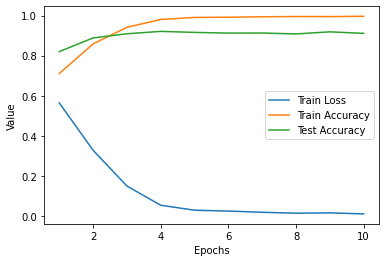

In [3]:

# 记录每个 epoch 的训练损失、训练准确率和测试准确率
train_losses = []
train_accuracies = []
test_accuracies = []

# 训练模型
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0.0
    correct = 0
    total = 0
    
    # 在每个迭代步骤中，获取批次数据并进行前向传播、损失计算和反向传播
    for inputs, keywords, labels in trainloader:
        # 省略训练步骤的代码
        model.train()
        inputs = inputs.to(torch.long).to(device)  # 将输入序列转换为torch.LongTensor类型
        keywords = keywords.to(torch.long).to(device)  # 将关键词序列转换为torch.LongTensor类型
        labels = labels.to(torch.long).to(device)  # 将标签转换为torch.cuda.LongTensor类型
        
        optimizer.zero_grad()
        
        outputs = model(inputs, keywords)  # 进行前向传播，注意传入关键词序列
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    
    # 打印每个 epoch 的训练损失和准确率
    print(f"Epoch {epoch+1}/{num_epochs}: Loss = {total_loss/len(trainloader):.4f}, Accuracy = {correct/total:.4f}")
    # 在每个 epoch 结束后在测试集上评估模型
    model.eval()
    test_correct = 0
    test_total = 0
    for test_inputs, test_keywords, test_labels in testloader:
        test_inputs = test_inputs.to(torch.long).to(device)
        test_keywords = test_keywords.to(torch.long).to(device)
        test_labels = test_labels.to(torch.long).to(device)
        
        test_outputs = model(test_inputs, test_keywords)
        _, test_predicted = test_outputs.max(1)
        test_correct += test_predicted.eq(test_labels).sum().item()
        test_total += test_labels.size(0)
    
    # 计算损失和准确率
    epoch_loss = total_loss / len(trainloader)
    epoch_train_accuracy = correct / total
    epoch_test_accuracy = test_correct / test_total
    
    # 保存损失和准确率
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_train_accuracy)
    test_accuracies.append(epoch_test_accuracy)
    
    # 打印每个 epoch 的训练损失和准确率以及测试准确率
    print(f"Epoch {epoch+1}/{num_epochs}: Loss = {epoch_loss:.4f}, Train Accuracy = {epoch_train_accuracy:.4f}, Test Accuracy = {epoch_test_accuracy:.4f}")

# 绘制损失和准确率图表
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()